# Deep Convolutional Generative Adversarial Network
https://arxiv.org/pdf/1511.06434.pdf

In [1]:
#%matplotlib ipympl  
%matplotlib inline

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Convolution2DTranspose, LeakyReLU, ReLU, BatchNormalization, Dropout, Flatten
from tensorflow.keras.activations import tanh
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import albumentations as A
import imgaug as IA

import random
import tqdm
tf.config.run_functions_eagerly(True)

In [2]:
IMG_SIZE = [64, 64]
SEED_SIZE = 128
MINIBATCH = 32
EPOCH = 150

SOMETIMES = lambda aug: IA.augmenters.Sometimes(0.2, aug)

PREPROCESS_SEQ = IA.augmenters.Sequential([
    SOMETIMES(IA.augmenters.Crop(percent=(0, 0.3))),
    SOMETIMES(IA.augmenters.Fliplr(p = 0.2)),
    SOMETIMES(IA.augmenters.Cutout()),  # replace one squared area within the image by a constant intensity value
    SOMETIMES(IA.augmenters.Affine(rotate = (-25,25) ))
], random_order=True) 

In [3]:
def Load_Images() -> list:
    """Load the images from Simpsons folder

    Returns:
        list: return a list of tuples like: (path, img)
    """
    Paths_Imgs = [(path, cv2.cvtColor(cv2.resize(cv2.imread(path),IMG_SIZE),cv2.COLOR_BGR2RGB)) for path in glob.glob("./Simpsons/cropped/*")]
    return zip(*Paths_Imgs)

In [4]:
def Preprocess_Images(imgs: list, type_: str):
    """Scale input values to [-1,1] and apply Image Augmentation Techniques

    Args:
        imgs (list): list of images

    Returns:
        _type_: list of preprocessed images
    """
   
    Preprocessed_Imgs = np.array(imgs)
       
    #Apply Image Augmentation techniques
    Preprocessed_Imgs = PREPROCESS_SEQ(images = Preprocessed_Imgs)

    #Change background to white
    Preprocessed_Imgs[Preprocessed_Imgs == 0] = 255

    #Scale image to [-1,1]
    if type_ != 'Generator':
        Preprocessed_Imgs = (Preprocessed_Imgs / 127.5) - 1

    return tf.convert_to_tensor(Preprocessed_Imgs, dtype=tf.float32)

In [5]:
Generator = Sequential([
    Dense(8*8*128,input_shape = (SEED_SIZE,),kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    Reshape((8,8,128)),
    
    Convolution2DTranspose(filters=128, kernel_size = 5, strides=(2,2), padding = 'same', use_bias=False,kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    ReLU(),
    tf.keras.layers.Dropout(0.2),

    Convolution2DTranspose(filters=256, kernel_size = 5, strides=(2,2), padding = 'same', use_bias=False,kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    ReLU(),
    tf.keras.layers.Dropout(0.2),

    #64x64x512
    Convolution2DTranspose(filters=512, kernel_size = 5, strides=(2,2), padding = 'same', use_bias=False,kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    ReLU(),
    tf.keras.layers.Dropout(0.2),

    #Convolution2DTranspose(filters=1024, kernel_size = (4,4), strides=(2,2), padding = 'same'),
    #BatchNormalization(),
    #ReLU(),
    #tf.keras.layers.Dropout(0.2),

    Conv2D(filters = 3, kernel_size = (4,4), activation='tanh', padding='same', use_bias=False,kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02))
])

In [6]:
Discriminator = Sequential([
    Conv2D(filters = 64, input_shape = [1] + IMG_SIZE + [3], kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias=False, kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias=False, kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters = 256, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias=False, kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters = 512, kernel_size = (5,5), strides = (2,2), padding = 'same', use_bias=False, kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters = 1024, kernel_size = (5,5), strides = 1, padding = 'same', use_bias=False, kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02)),
    BatchNormalization(),
    LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.2),

    Flatten(),
    Dense(1, activation = 'sigmoid', use_bias=False,kernel_initializer = tf.keras.initializers.random_normal(mean = 0.00, stddev=0.02))
])

## Loss Definition

In [7]:
loss_BinCrossEnt = BinaryCrossentropy()

## Discriminator Loss

$$L^D = - \sum_{i:y_i = 1} \log{\hat{y_i}} - \sum_{i:y_i = 0} \log{(1 - \hat{y_i})}$$

In [8]:
def Discriminator_Loss(Real_output, Fake_output):
    Real_loss = loss_BinCrossEnt(tf.ones_like(Real_output), Real_output)
    Fake_loss = loss_BinCrossEnt(tf.zeros_like(Fake_output), Fake_output)
    Total_loss =  (Real_loss + Fake_loss) / 2

    #Total_loss = -1/2 * tf.reduce_sum(tf.keras.backend.log( Real_output )) - tf.reduce_sum(tf.keras.backend.log( 1 - Fake_output ))
    return Total_loss

## Generator Loss

$$ L^G =  - \sum_{i:y_i = 0} \log{\hat{y_i}}$$

In [9]:
def Generator_Loss(output):
    Total_loss = loss_BinCrossEnt(tf.ones_like(output),output)
    #Total_loss = - tf.reduce_sum( tf.keras.backend.log( output ) )
    return Total_loss

## Training initialization

In [10]:
#Hyper-parameters from the paper
Generator_opt =  Adam(learning_rate=0.0002, beta_1=0.5)
Discriminator_opt = Adam(learning_rate=0.0002, beta_1=0.5)

In [11]:
@tf.function
def Step(batch):

    #Create noise input for the Generator
    Z = tf.random.normal(shape = (MINIBATCH, SEED_SIZE))

    fake_Images = Generator(Z)
    fake_Images = tf.reshape(fake_Images, [MINIBATCH] + [1] + IMG_SIZE + [3])

    #Calculate loss fot the Discriminator
    with tf.GradientTape() as D_tape:
        real_D = Discriminator(batch)
        fake_D = Discriminator(fake_Images)

        loss_D = Discriminator_Loss(real_D, fake_D)
    
    #Calculate gradient for each model and train
    g_D = D_tape.gradient(loss_D, Discriminator.trainable_variables)
    Discriminator_opt.apply_gradients( zip(g_D, Discriminator.trainable_variables) )

    with tf.GradientTape() as G_tape:
        fake_Images = Generator(Z)
        fake_Images = tf.reshape(fake_Images, [MINIBATCH] + [1] + IMG_SIZE + [3])
        fake_out = Discriminator(fake_Images)
        G_loss = Generator_Loss(fake_out)

    #Calculate gradient for each model adn train
    g_G = G_tape.gradient(G_loss, Generator.trainable_variables)
    Generator_opt.apply_gradients( zip(g_G, Generator.trainable_variables) )
    

    return G_loss, loss_D

In [12]:
Paths, Images = Load_Images()

In [13]:
def Sample_Images(epoch):
    try:
        plt.close()
    except:
        pass

    Z = tf.random.normal(shape = (25, SEED_SIZE), seed=3)
    generated_imgs = Generator(Z, training = False)

    generated_imgs = tf.reshape(generated_imgs, shape = [25]  + IMG_SIZE + [3])
    generated_imgs = tf.cast((generated_imgs+1)*127.5, tf.uint8)


    fig, axs = plt.subplots(5,5)
    count = 0

    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(generated_imgs[count])
            axs[i,j].axis('off')
            count += 1
    
    fig.savefig("Gen_Imgs/%d.png" % epoch)
    plt.show()
    

Epoch: 150, G_loss: 4.048587799072266, D_los: 0.07548357546329498 


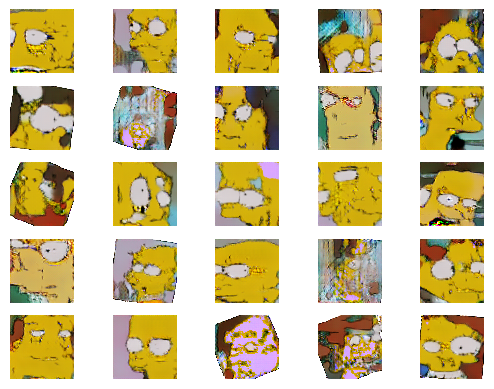

In [14]:
IMGS = []
G_L = []
D_L = []


for epoch in range(EPOCH + 1):
    Batch = tf.data.Dataset.from_tensor_slices(Preprocess_Images(Images, ' ')).shuffle(len(Images)).batch(MINIBATCH, drop_remainder=True)

    with tqdm.tqdm(total = int(len(Images)//MINIBATCH)) as pbar:
        for P_Images in Batch:        
            P_Images = tf.reshape(P_Images, shape = [MINIBATCH] + [1] + IMG_SIZE + [3])
            G_Loss, D_Loss = Step(P_Images)
            pbar.update(1)

    G_L.append(G_Loss)
    D_L.append(D_Loss)

    clear_output(wait=True)
    pbar.write("Epoch: {}, G_loss: {}, D_los: {} ".format(epoch, G_Loss.numpy(), D_Loss.numpy()))

    if epoch % 5 == 0:
        Sample_Images(epoch)
    


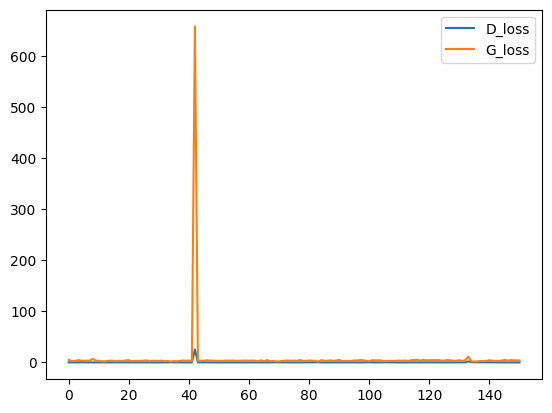

In [15]:
plt.plot(D_L, label = 'D_loss')
plt.plot(G_L, label = 'G_loss')
plt.legend()

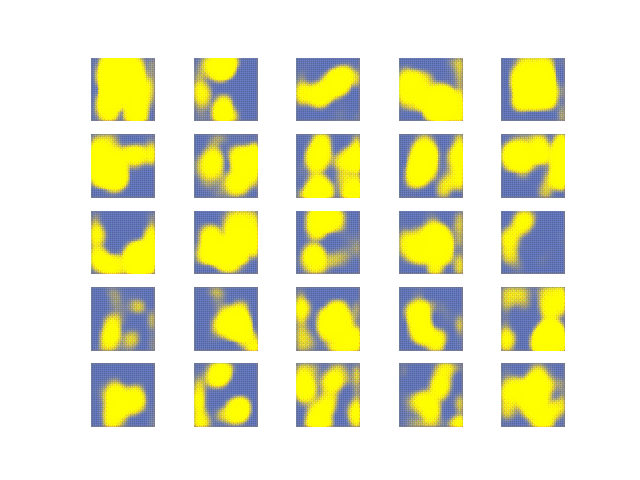

In [16]:
import imageio
from IPython.display import Image
import glob


imgs = [cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB) for img in glob.glob('./Gen_Imgs/*')]
imageio.mimsave('dcgan.gif', imgs, fps = 2)
Image( './dcgan.gif', format='gif')